In [36]:
import numpy as np
import os
import matplotlib.pyplot as plt
from os import environ
from citrination_client import CitrinationClient
from citrination_client import *
from pypif import pif
from pypif.obj import *
import csv
import pandas as pd
%matplotlib inline

# Getting Flexural Strength CSV

In [ ]:
%env CITRINATION_API_KEY = xtptah7YrtcUgYGWvzZynQtt 

In [ ]:
client = CitrinationClient(environ['CITRINATION_API_KEY'], 'https://citrination.com')
dataset_id = '151803'
value_query = FieldQuery(extract_as="Flexural Strength", extract_all=True)
property_query = PropertyQuery(name=FieldQuery(filter=[Filter(equal="Flexural Strength")]), value=value_query)
formula_query = ChemicalFieldQuery(extract_as="formula")
system_query = PifSystemQuery(chemical_formula=formula_query, properties=property_query)
dataset_query = DatasetQuery(id=[Filter(equal=dataset_id)])
data_query = DataQuery(dataset=dataset_query, system=system_query)
pif_query = PifSystemReturningQuery(size=10000, random_results=False, query=data_query)
search_result = client.search.pif_search(pif_query)

print("We found {} records".format(len(search_result.hits)))
print([x.extracted for x in search_result.hits[0:5]])

In [ ]:
rows = []
pif_records = [x.system for x in search_result.hits]
for system in pif_records:
    
    cryst_value= None
    for prop in system.properties:
        if prop.name == 'Crystallinity':
            cryst_value= prop.scalars[0].value
    for prop in system.properties:
        if prop.name == "Flexural Strength" and prop.units == "MPa":
            for cond in prop.conditions:
                if cond.name == "Temperature":
                    if cond.units=="$^{\\circ}$C":
                        add= 273.
                    elif cond.units=='K':
                        add= 0.
                    if len(prop.scalars) == len(cond.scalars):
                        for prop_sca, cond_sca in zip(prop.scalars, cond.scalars):
                            row = [system.chemical_formula, prop_sca.value, (float(cond_sca.value)+add), 
                                    cryst_value, system.references[0].citation]
                            rows.append(row)

with open('flexural_strength_temperature.csv', 'w') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Formula', 'Flexural Strength (MPa)', 'Temperature (K)', 'Crystallinity','Reference'])
    writer.writerows(rows)

In [ ]:
# rows = []
# pif_records = [x.system for x in search_result.hits]
# for system in pif_records:
#     if "x" not in system.chemical_formula and "." not in system.chemical_formula:
#         cryst_value= None
#         for prop in system.properties:
#             if prop.name == 'Crystallinity':
#                 cryst_value= prop.scalars[0].value
#         for prop in system.properties:
#             if prop.name == "Flexural Strength" and prop.units == "MPa":
#                 for cond in prop.conditions:
#                     if cond.name == "Temperature":
#                         if cond.units=="$^{\\circ}$C":
#                             add= 273.
#                         elif cond.units=='K':
#                             add= 0.
#                         if len(prop.scalars) == len(cond.scalars):
#                             for prop_sca, cond_sca in zip(prop.scalars, cond.scalars):
#                                 row = [system.chemical_formula, prop_sca.value, (float(cond_sca.value)+add), 
#                                        cryst_value, system.references[0].citation]
#                                 rows.append(row)

# with open('flexural_strength_temperature.csv', 'w') as csvfile:
#     writer = csv.writer(csvfile)
#     writer.writerow(['Formula', 'Flexural Strength (MPa)', 'Temperature (K)', 'Crystallinity','Reference'])
#     writer.writerows(rows)

## Clean up the raw CSV and generate composition

In [2]:
import re
from matminer.utils.conversions import str_to_composition

In [3]:
fs= pd.read_csv('flexural_strength_temperature.csv', encoding = "ISO-8859-1")
fs.head()

,Formula,Flexural Strength (MPa),Temperature (K),Crystallinity,Reference
0,Si3N4.xY2O3.ySrO,707,298.0,Polycrystalline,Ceramic Technology Project Data Base: Septemb...
1,Si3N4.xY2O3.ySrO,609,1373.0,Polycrystalline,Ceramic Technology Project Data Base: Septemb...
2,Si3N4.xY2O3.ySrO,649,1373.0,Polycrystalline,Ceramic Technology Project Data Base: Septemb...
3,Si3N4.xY2O3.ySrO,675,1373.0,Polycrystalline,Ceramic Technology Project Data Base: Septemb...
4,Si3N4.xY2O3.ySrO,697,1373.0,Polycrystalline,Ceramic Technology Project Data Base: Septemb...


In [4]:
len(fs['Reference'].unique())

117

In [5]:
print(fs.shape)
# Determine number of polycrystalline / single crystal samples
N_polyX = fs[fs['Crystallinity']=='Polycrystalline']['Crystallinity'].shape
N_singleX = fs[fs['Crystallinity']=='Single Crystal']['Crystallinity'].shape
print('Polycrystalline: {0}, Single crystal: {1}'.format(N_polyX, N_singleX))

(1934, 5)
Polycrystalline: (1776,), Single crystal: (19,)


In [6]:
#Fill NaN values in crystallinity with polycrystalline:
fs['Crystallinity'] = fs['Crystallinity'].fillna('Polycrystalline')
N_polyX = fs[fs['Crystallinity']=='Polycrystalline']['Crystallinity'].shape
N_singleX = fs[fs['Crystallinity']=='Single Crystal']['Crystallinity'].shape
print('Polycrystalline: {0}, Single crystal: {1}'.format(N_polyX, N_singleX))

Polycrystalline: (1915,), Single crystal: (19,)


In [7]:
# Check how many values cannot simply be transformed from string to int
#also locate which row the errors occur in

N_errors, N_total, row = 0, 0, -1
for entry in fs['Flexural Strength (MPa)']:
    row+=1
    try:
        pd.Series([entry]).astype(float)
    except:
        N_errors +=1
        print(entry)
        print(row)
        
    finally:
        N_total +=1

print('{0} errors in {1} samples'.format(N_errors, N_total))

359 (15%)
1016
1 errors in 1934 samples


In [8]:
fs.loc[1016, 'Reference']

'Material Properties of a Sintered $\\alpha$-SiC, R.G. Munro, Journal of Physical and Chemical Reference Data, Vol. 26 5, pp. 1195-1203 (1997), published by American Chemical Society.'

In [9]:
fs.loc[fs['Reference']=='Material Properties of a Sintered $\\alpha$-SiC, R.G. Munro, Journal of Physical and Chemical Reference Data, Vol. 26 5, pp. 1195-1203 (1997), published by American Chemical Society.']

,Formula,Flexural Strength (MPa),Temperature (K),Crystallinity,Reference
1016,SiC,359 (15%),293.0,Polycrystalline,Material Properties of a Sintered $\alpha$-SiC...
1017,SiC,359,773.0,Polycrystalline,Material Properties of a Sintered $\alpha$-SiC...
1018,SiC,397,1273.0,Polycrystalline,Material Properties of a Sintered $\alpha$-SiC...
1019,SiC,437,1473.0,Polycrystalline,Material Properties of a Sintered $\alpha$-SiC...
1020,SiC,446,1673.0,Polycrystalline,Material Properties of a Sintered $\alpha$-SiC...
1021,SiC,446,1773.0,Polycrystalline,Material Properties of a Sintered $\alpha$-SiC...


In [10]:
fs.at[1016, 'Flexural Strength (MPa)'] = 359
fs.loc[1016]

Formula                                                                  SiC
Flexural Strength (MPa)                                                  359
Temperature (K)                                                          293
Crystallinity                                                Polycrystalline
Reference                  Material Properties of a Sintered $\alpha$-SiC...
Name: 1016, dtype: object

In [11]:
fs['Flexural Strength (MPa)'] = fs['Flexural Strength (MPa)'].astype(float)
fs.sort_values(by='Flexural Strength (MPa)')

,Formula,Flexural Strength (MPa),Temperature (K),Crystallinity,Reference
161,ZrO2.xY2O3,13.0,1018.0,Polycrystalline,"Youngs Modulus, Flexural Strength, and Fractur..."
129,ZrO2.xY2O3,14.0,1269.0,Polycrystalline,"Youngs Modulus, Flexural Strength, and Fractur..."
182,ZrO2.xY2O3,14.0,1042.0,Polycrystalline,"Youngs Modulus, Flexural Strength, and Fractur..."
1461,Al2O3,15.0,1873.0,Polycrystalline,Creep of Polycrystalline Al2O3 Ceramics at Hig...
183,ZrO2.xY2O3,19.0,1243.0,Polycrystalline,"Youngs Modulus, Flexural Strength, and Fractur..."
1457,Al2O3,20.0,1873.0,Polycrystalline,Creep of Polycrystalline Al2O3 Ceramics at Hig...
136,ZrO2.xY2O3,20.0,991.0,Polycrystalline,"Youngs Modulus, Flexural Strength, and Fractur..."
150,ZrO2.xY2O3,21.0,1018.0,Polycrystalline,"Youngs Modulus, Flexural Strength, and Fractur..."
151,ZrO2.xY2O3,21.0,1267.0,Polycrystalline,"Youngs Modulus, Flexural Strength, and Fractur..."
155,ZrO2.xY2O3,22.0,1777.0,Polycrystalline,"Youngs Modulus, Flexural Strength, and Fractur..."


In [12]:
N_unique_entries = len(fs['Formula'].unique())
print('There are just {0} unique entries in the {1} materials.'.format(N_unique_entries,fs.shape[0]))

There are just 73 unique entries in the 1934 materials.


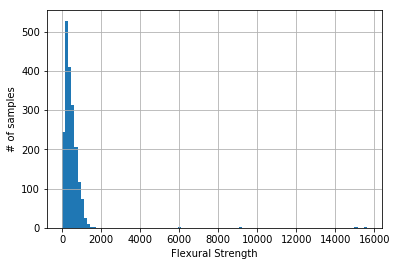

In [13]:
#look at the disribution of the data 
fsn = fs['Flexural Strength (MPa)']
fsn = pd.to_numeric(fsn, errors = 'coerce')
fsn.hist(bins=100)
plt.xlabel('Flexural Strength')
plt.ylabel('# of samples')
plt.show()

In [14]:
fs.loc[1673, 'Reference']

'Strength of Diamond, D.J. Weidner, Y. Wang, and M.T. Vaughan, Science, Vol. 266, pp. 419-421 (1994), published by American Association for the Advancement of Science.'

In [15]:
#remove the outliers from the dataset in case they give the machine learning models toruble
fs = fs[fs.Reference != 'Strength of Diamond, D.J. Weidner, Y. Wang, and M.T. Vaughan, Science, Vol. 266, pp. 419-421 (1994), published by American Association for the Advancement of Science.']

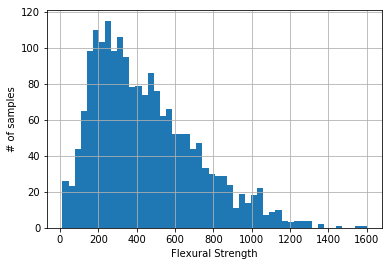

In [16]:
fsn = fs['Flexural Strength (MPa)']
fsn = pd.to_numeric(fsn, errors = 'coerce')
fsn.hist(bins=50)
plt.xlabel('Flexural Strength')
plt.ylabel('# of samples')
plt.show()

In [17]:
fs.shape

(1930, 5)

In [18]:

# Parse the chemicalFormula
def formula_decompose(formula):
    '''
    decompose chemical formula 
    return
        composition: list, [(element,num),...]
            element: string
            num: string, can be math expression such as '1+0.5x'
    '''

    comp = []
    p = re.compile(r'(\d?[w-z]?)([A-Z][a-u]?)(\d*\+?\-?\d*\.?\d*[w-z]?)')

    #split the chemical formula if there is dots, but not for cases like Mg1.5x
    if re.search(r'\.', formula) and not re.search(r'\d+\.\d[w-z]', formula): 
        formula = formula.split('.')
        for item in formula:
            prefactor = '1'
            for i in re.findall(p, item):
                pre, elem, num = i
                if pre:
                    prefactor = pre
                if num == '':
                    num = '1'
                num = prefactor + '*({})'.format(num)
                comp.append((elem, num))
    else:
        prefactor = '1'
        for i in re.findall(p, formula):
            pre, elem, num = i
            if pre:
                prefactor = pre
            if num == '':
                num = '1'
            num = prefactor + '*({})'.format(num)
            comp.append((elem, num))
    return comp 

def formula_reconstruct(composition, x=0.1, y=0.1, z=0.1, w=0.1):
    '''
    reconstruct chemical formula from composition
    composition in form of [(element,num), (element,num),...]
        element: string
        num: string, can be math expression such as '1+0.5x'

    return 
        flat chemcial formula: string, such as 'Ti1.5Cu0.1Au1.0'
    '''
    flat_list = []
    for (elem, num) in composition:
        num = re.sub(r'(\d)([w-z])', r'\1*\2', num) #convert 5x to 5*x
        flat_list.append(elem)
        flat_list.append(format(eval(num), '.1f'))
    return ''.join(flat_list)
  
def formula_parser(formula):
    return formula_reconstruct(formula_decompose(formula))

In [19]:
fs1 = fs.copy()
fs1["flatFormula"] = fs1["Formula"].map(formula_parser)
fs1.head()
#fs1.dropna(axis=1).head()

,Formula,Flexural Strength (MPa),Temperature (K),Crystallinity,Reference,flatFormula
0,Si3N4.xY2O3.ySrO,707.0,298.0,Polycrystalline,Ceramic Technology Project Data Base: Septemb...,Si3.0N4.0Y0.2O0.3Sr0.1O0.1
1,Si3N4.xY2O3.ySrO,609.0,1373.0,Polycrystalline,Ceramic Technology Project Data Base: Septemb...,Si3.0N4.0Y0.2O0.3Sr0.1O0.1
2,Si3N4.xY2O3.ySrO,649.0,1373.0,Polycrystalline,Ceramic Technology Project Data Base: Septemb...,Si3.0N4.0Y0.2O0.3Sr0.1O0.1
3,Si3N4.xY2O3.ySrO,675.0,1373.0,Polycrystalline,Ceramic Technology Project Data Base: Septemb...,Si3.0N4.0Y0.2O0.3Sr0.1O0.1
4,Si3N4.xY2O3.ySrO,697.0,1373.0,Polycrystalline,Ceramic Technology Project Data Base: Septemb...,Si3.0N4.0Y0.2O0.3Sr0.1O0.1


In [20]:
fs1["composition"] =fs1["flatFormula"].transform(str_to_composition)
fs1.head()

,Formula,Flexural Strength (MPa),Temperature (K),Crystallinity,Reference,flatFormula,composition
0,Si3N4.xY2O3.ySrO,707.0,298.0,Polycrystalline,Ceramic Technology Project Data Base: Septemb...,Si3.0N4.0Y0.2O0.3Sr0.1O0.1,"(Si, N, Y, O, Sr)"
1,Si3N4.xY2O3.ySrO,609.0,1373.0,Polycrystalline,Ceramic Technology Project Data Base: Septemb...,Si3.0N4.0Y0.2O0.3Sr0.1O0.1,"(Si, N, Y, O, Sr)"
2,Si3N4.xY2O3.ySrO,649.0,1373.0,Polycrystalline,Ceramic Technology Project Data Base: Septemb...,Si3.0N4.0Y0.2O0.3Sr0.1O0.1,"(Si, N, Y, O, Sr)"
3,Si3N4.xY2O3.ySrO,675.0,1373.0,Polycrystalline,Ceramic Technology Project Data Base: Septemb...,Si3.0N4.0Y0.2O0.3Sr0.1O0.1,"(Si, N, Y, O, Sr)"
4,Si3N4.xY2O3.ySrO,697.0,1373.0,Polycrystalline,Ceramic Technology Project Data Base: Septemb...,Si3.0N4.0Y0.2O0.3Sr0.1O0.1,"(Si, N, Y, O, Sr)"


In [21]:
print(len(fs1['composition'].unique()))
print(len(fs1['Formula'].unique()))

70
72


## Featurize the Dataframe

In [22]:
from matminer.featurizers import composition
from matminer.featurizers.composition import ElementFraction

In [23]:
# select featurizers

# elemental property
ep_feat = composition.ElementProperty.from_preset(preset_name="magpie")

# atomic packing efficiency
ape_feat= composition.AtomicPackingEfficiency()

#element fraction
ep_frac = ElementFraction()

In [24]:
fsg= fs1.drop_duplicates(['Formula','Temperature (K)','Crystallinity'])
print('Shape of dataset with no duplicates: %s'%str(fsg.shape))
print('Number of unique chemical Formulae in the dataset: %i'%(fsg['Formula'].nunique()))
fsg.head()

Shape of dataset with no duplicates: (553, 7)
Number of unique chemical Formulae in the dataset: 72


,Formula,Flexural Strength (MPa),Temperature (K),Crystallinity,Reference,flatFormula,composition
0,Si3N4.xY2O3.ySrO,707.0,298.0,Polycrystalline,Ceramic Technology Project Data Base: Septemb...,Si3.0N4.0Y0.2O0.3Sr0.1O0.1,"(Si, N, Y, O, Sr)"
1,Si3N4.xY2O3.ySrO,609.0,1373.0,Polycrystalline,Ceramic Technology Project Data Base: Septemb...,Si3.0N4.0Y0.2O0.3Sr0.1O0.1,"(Si, N, Y, O, Sr)"
5,Si3N4.xY2O3.ySrO,537.0,1473.0,Polycrystalline,Ceramic Technology Project Data Base: Septemb...,Si3.0N4.0Y0.2O0.3Sr0.1O0.1,"(Si, N, Y, O, Sr)"
7,Si3N4.xY2O3.ySrO,513.0,1573.0,Polycrystalline,Ceramic Technology Project Data Base: Septemb...,Si3.0N4.0Y0.2O0.3Sr0.1O0.1,"(Si, N, Y, O, Sr)"
10,ZrO2.xMgO,677.0,298.0,Polycrystalline,Characterization Studies of Transformation-Tou...,Zr1.0O2.0Mg0.1O0.1,"(Zr, O, Mg)"


In [25]:
fsg= ep_feat.featurize_dataframe(fsg,col_id='composition',ignore_errors=True)
fsg= ape_feat.featurize_dataframe(fsg,col_id='composition',ignore_errors=True)
fsg = ep_frac.featurize_dataframe(fsg, col_id = "composition", ignore_errors = True)


In [26]:
fsg.to_pickle('flexural_strength_temperature_with_features.pkl')
print('Shape of dataset with Features: %s'%str(fsg.shape))

Shape of dataset with Features: (553, 247)


In [27]:
fsg2= fs1.drop_duplicates(['Formula','Temperature (K)','Crystallinity'])
fsg2= ep_feat.featurize_dataframe(fsg2,col_id='composition',ignore_errors=True)
fsg2 = ep_frac.featurize_dataframe(fsg2, col_id = "composition", ignore_errors = True)
fsg2.to_pickle('flexural_strength_temperature_with_less_features.pkl')
print('Shape of dataset with Features: %s'%str(fsg2.shape))

Shape of dataset with Features: (553, 242)


## Try some ML algorithms

In [65]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, cross_val_score
from sklearn import preprocessing

In [68]:
print(fsg.isnull().values.any())
fsgd = fsg.dropna()
print(fsgd.isnull().values.any())
print(fsgd.shape)

y = fsgd['Flexural Strength (MPa)'].values
print(y.shape)
excluded = ['Formula', 'Crystallinity', 'Reference', 'flatFormula', 'composition', 'Flexural Strength (MPa)']
X = fsgd.drop(excluded, axis=1)
X = X.astype(float)
X1 = X.values
X1 = preprocessing.scale(X1)
print(X1.shape)

lr = LinearRegression()
lr.fit(X1,y)

# get fit statistics
print('training R2 = ' + str(round(lr.score(X1, y), 3)))
print('training RMSE = %.3f' % np.sqrt(mean_squared_error(y_true=y, y_pred=lr.predict(X1))))

True
False
(544, 247)
(544,)
(544, 241)
training R2 = 0.636
training RMSE = 160.613


In [69]:
crossvalidation = KFold(n_splits=10, shuffle=False, random_state=1)
scores = cross_val_score(lr, X1, y, scoring='neg_mean_squared_error', cv=crossvalidation, n_jobs=1)
rmse_scores = [np.sqrt(abs(s)) for s in scores]
r2_scores = cross_val_score(lr, X1, y, scoring='r2', cv=crossvalidation, n_jobs=1)

print('Cross-validation results:')
print('Folds: %i, mean R2: %.3f' % (len(scores), np.mean(np.abs(r2_scores))))
print('Folds: %i, mean RMSE: %.3f' % (len(scores), np.mean(np.abs(rmse_scores))))

Cross-validation results:
Folds: 10, mean R2: 909210208563200144703488.000
Folds: 10, mean RMSE: 101729438243449.406


In [70]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=50, random_state=1)

rf.fit(X1, y)
print('training R2 = ' + str(round(rf.score(X1, y), 3)))
print('training RMSE = %.3f' % np.sqrt(mean_squared_error(y_true=y, y_pred=rf.predict(X1))))

training R2 = 0.917
training RMSE = 76.778


In [71]:
# compute cross validation scores for random forest model
r2_scores = cross_val_score(rf, X1, y, scoring='r2', cv=crossvalidation, n_jobs=-1)
scores = cross_val_score(rf, X1, y, scoring='neg_mean_squared_error', cv=crossvalidation, n_jobs=-1)
rmse_scores = [np.sqrt(abs(s)) for s in scores]

print('Cross-validation results:')
print('Folds: %i, mean R2: %.3f' % (len(scores), np.mean(np.abs(r2_scores))))
print('Folds: %i, mean RMSE: %.3f' % (len(scores), np.mean(np.abs(rmse_scores))))

Cross-validation results:
Folds: 10, mean R2: 0.369
Folds: 10, mean RMSE: 229.330


In [74]:
#using X not X1
from sklearn.model_selection import train_test_split
X['formula'] = fsgd['Formula']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
train_formula = X_train['formula']
X_train = X_train.drop('formula', axis=1)
test_formula = X_test['formula']
X_test = X_test.drop('formula', axis=1)

rf_reg = RandomForestRegressor(n_estimators=50, random_state=1)
rf_reg.fit(X_train, y_train)

# get fit statistics
print('training R2 = ' + str(round(rf_reg.score(X_train, y_train), 3)))
print('training RMSE = %.3f' % np.sqrt(mean_squared_error(y_true=y_train, y_pred=rf_reg.predict(X_train))))
print('test R2 = ' + str(round(rf_reg.score(X_test, y_test), 3)))
print('test RMSE = %.3f' % np.sqrt(mean_squared_error(y_true=y_test, y_pred=rf_reg.predict(X_test))))

training R2 = 0.914
training RMSE = 79.829
test R2 = 0.566
test RMSE = 159.006
